In [1]:
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from cpmix_utils import weight_fun, calc_weights, calc_min_distances_discrete, calculate_metrics

In [3]:
ls ../monit_npy/

REGRESSION_nn_rhorho_Variant-All_Unweighted_False_NO/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_10/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_11/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_12/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_13/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_14/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_15/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_16/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_17/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_18/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_19/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_2/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_20/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_21/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_21_WEIGHTS_SUBS[0, 10]/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_21_WEIGHTS_SUBS[0, 2]/
nn_rhorho_Variant-All_Unweighted_False

In [4]:
filenames = [f'../monit_npy/nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_{i}' for i in range(2,51)]

In [5]:
def get_filename_for_class(class_num, subset=None):
    d = f'../monit_npy/nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_{class_num}'
    if subset:
        d += "_WEIGHTS_SUBS" + str(subset)
    return d

In [6]:
ls ../monit_npy/nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_50

softmax_calc_w.npy   softmax_preds_w.npy


In [7]:
filenames[0]

'../monit_npy/nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_2'

In [8]:
def calculate_metrics_for_numclass(directory, num_class):
    calc_w = np.load(os.path.join(directory, 'softmax_calc_w.npy'))
    preds_w = np.load(os.path.join(directory, 'softmax_preds_w.npy'))
    return calculate_metrics(num_class, calc_w, preds_w)

In [9]:
metrics = [calculate_metrics_for_numclass(filenames[i], i+2) for i in range(49)]

In [10]:
metrics = np.stack(metrics)

In [11]:
np.save( 'metrics_multiclass.npy', metrics,)

# Accuracy

Text(0,0.5,'Accuracy')

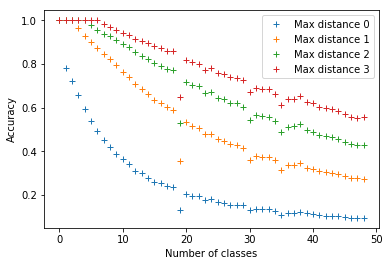

In [12]:
plt.plot(metrics[:, 0],'+', label='Max distance 0')
plt.plot(metrics[:, 1],'+', label='Max distance 1')
plt.plot(metrics[:, 2],'+', label='Max distance 2')
plt.plot(metrics[:, 3],'+', label='Max distance 3')
plt.legend(loc='upper right')
plt.xlabel('Number of classes')
plt.ylabel('Accuracy')

# Mean error

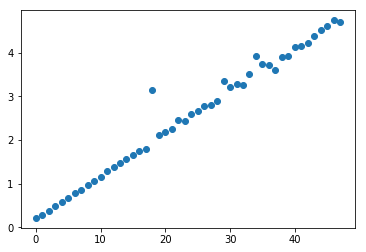

In [13]:
plt.plot(metrics[1:, 4], 'o')



# L1 Distance

Text(0,0.5,'l1')

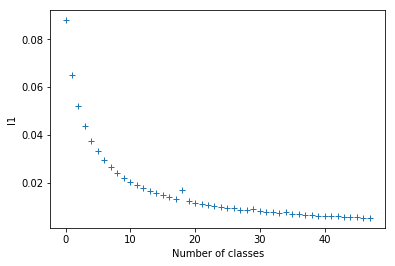

In [14]:
plt.plot(metrics[1:, 5], '+')
plt.xlabel("Number of classes")
plt.ylabel('l1')

# L2 Distance

Text(0,0.5,'l2')

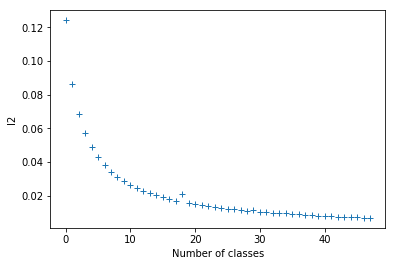

In [15]:
plt.plot(metrics[1:, 6], '+')
plt.xlabel("Number of classes")
plt.ylabel('l2')

# ROC AUC score

In [16]:
from sklearn.metrics import roc_auc_score
def calculate_roc_auc(pred_w, calc_w, index_a, index_b):
    n, num_classes = calc_w.shape
    true_labels = np.concatenate([np.ones(n), np.zeros(n)])
    preds = np.concatenate([pred_w[:, index_a], pred_w[:, index_a]])
    weights = np.concatenate([calc_w[:, index_a], calc_w[:, index_b]])

    return roc_auc_score(true_labels, preds, sample_weight=weights)

In [17]:
def test_roc_auc(directory, num_class):
    calc_w = np.load(os.path.join(directory, 'softmax_calc_w.npy'))
    preds_w = np.load(os.path.join(directory, 'softmax_preds_w.npy'))
    for i in range(0, num_class):
         print(i, 'roc_auc: {}'.format(calculate_roc_auc(preds_w, calc_w, 0, i)), 'maxroc_auc: {}'.format(calculate_roc_auc(calc_w, calc_w, 0, i)))

In [18]:
i = 21
test_roc_auc(get_filename_for_class(i), i)

0 roc_auc: 0.5000000000000004 maxroc_auc: 0.5000000000000102
1 roc_auc: 0.5043273048019564 maxroc_auc: 0.505715103706892
2 roc_auc: 0.5157686018206398 maxroc_auc: 0.5224470536108253
3 roc_auc: 0.5331939212487248 maxroc_auc: 0.5485427621387747
4 roc_auc: 0.5548875781537895 maxroc_auc: 0.5814323630193214
5 roc_auc: 0.578719927419587 maxroc_auc: 0.6178866679725444
6 roc_auc: 0.6023581559599771 maxroc_auc: 0.6543369626140604
7 roc_auc: 0.6234945971232256 maxroc_auc: 0.6872244359864048
8 roc_auc: 0.6400702436905967 maxroc_auc: 0.7133450183653228
9 roc_auc: 0.6504724937460067 maxroc_auc: 0.7301572263494819
10 roc_auc: 0.6536892207764278 maxroc_auc: 0.7360250862136876
11 roc_auc: 0.6494055204246585 maxroc_auc: 0.7303745760743253
12 roc_auc: 0.6380345446021924 maxroc_auc: 0.7137496733185276
13 roc_auc: 0.6206794027803705 maxroc_auc: 0.6877625770992603
14 roc_auc: 0.5990289744981194 maxroc_auc: 0.6549416675781581
15 roc_auc: 0.5751963930775128 maxroc_auc: 0.6184898953805829
16 roc_auc: 0.551514

In [19]:
i = 21
test_roc_auc(get_filename_for_class(i), i)

0 roc_auc: 0.5000000000000004 maxroc_auc: 0.5000000000000102
1 roc_auc: 0.5043273048019564 maxroc_auc: 0.505715103706892
2 roc_auc: 0.5157686018206398 maxroc_auc: 0.5224470536108253
3 roc_auc: 0.5331939212487248 maxroc_auc: 0.5485427621387747
4 roc_auc: 0.5548875781537895 maxroc_auc: 0.5814323630193214
5 roc_auc: 0.578719927419587 maxroc_auc: 0.6178866679725444
6 roc_auc: 0.6023581559599771 maxroc_auc: 0.6543369626140604
7 roc_auc: 0.6234945971232256 maxroc_auc: 0.6872244359864048
8 roc_auc: 0.6400702436905967 maxroc_auc: 0.7133450183653228
9 roc_auc: 0.6504724937460067 maxroc_auc: 0.7301572263494819
10 roc_auc: 0.6536892207764278 maxroc_auc: 0.7360250862136876
11 roc_auc: 0.6494055204246585 maxroc_auc: 0.7303745760743253
12 roc_auc: 0.6380345446021924 maxroc_auc: 0.7137496733185276
13 roc_auc: 0.6206794027803705 maxroc_auc: 0.6877625770992603
14 roc_auc: 0.5990289744981194 maxroc_auc: 0.6549416675781581
15 roc_auc: 0.5751963930775128 maxroc_auc: 0.6184898953805829
16 roc_auc: 0.551514

## Baseline

In [20]:
i = 21
subset = [0,6] # Run with option --WEIGHTS_SUBSET [0,6]
test_roc_auc(get_filename_for_class(i, subset), 2)

0 roc_auc: 0.4999999999999933 maxroc_auc: 0.5000000000000052
1 roc_auc: 0.6639896560945292 maxroc_auc: 0.6454566069027331


In [21]:
i = 21
subset = [0,10] # Run with option --WEIGHTS_SUBSET [0,10]
test_roc_auc(get_filename_for_class(i, subset), 2)

0 roc_auc: 0.5000000000000063 maxroc_auc: 0.5000000000000052
1 roc_auc: 0.701805957934322 maxroc_auc: 0.7221783356452286


In [22]:
i = 21
subset = [0,2] # Run with option --WEIGHTS_SUBSET [0,2]
test_roc_auc(get_filename_for_class(i, subset), 2)

0 roc_auc: 0.4999999999999986 maxroc_auc: 0.5000000000000052
1 roc_auc: 0.5568512762550901 maxroc_auc: 0.521384294099431


In [23]:
i = 21
subset = [0,8] # Run with option --WEIGHTS_SUBSET [0,8]
test_roc_auc(get_filename_for_class(i, subset), 2)

0 roc_auc: 0.4999999999999992 maxroc_auc: 0.5000000000000052
1 roc_auc: 0.6897154024886555 maxroc_auc: 0.7009590049115341


# Accuracy distance

In [24]:
def plot_distr(directory, num_class):
    calc_w = np.load(os.path.join(directory, 'softmax_calc_w.npy'))
    preds_w = np.load(os.path.join(directory, 'softmax_preds_w.npy'))
    pred_arg_maxs = np.argmax(preds_w, axis=1)
    calc_arg_maxs = np.argmax(calc_w, axis=1)
    min_distances = calc_min_distances_discrete(pred_arg_maxs, calc_arg_maxs, num_class)
    
    bins = list(range(int(np.min(min_distances)), int(np.max(min_distances)+2)))
    plt.hist(min_distances, bins=bins, histtype='step')
    plt.xlabel('Prediction error distance')
    

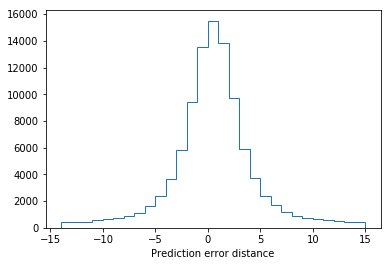

In [25]:
i = 30
plot_distr(get_filename_for_class(i), i)

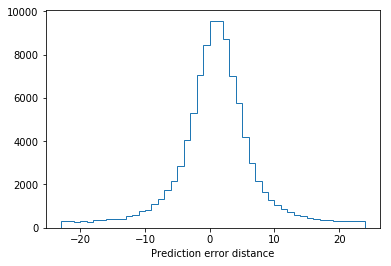

In [26]:
i = 48
plot_distr(get_filename_for_class(i), i)

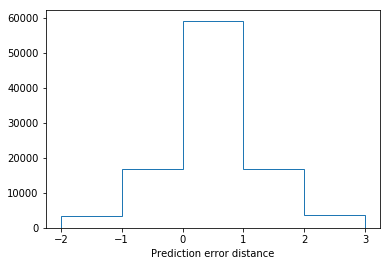

In [27]:
i = 6
plot_distr(get_filename_for_class(i), i)

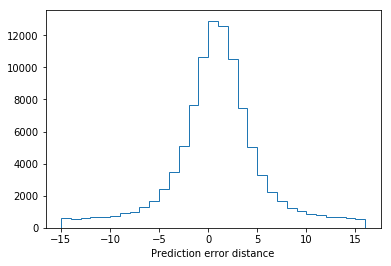

In [28]:
i = 32
plot_distr(get_filename_for_class(i), i)

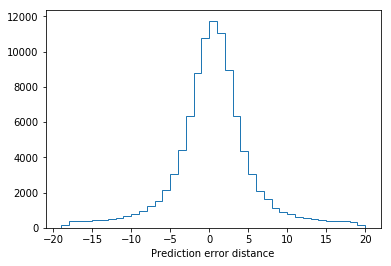

In [29]:
i = 39
plot_distr(get_filename_for_class(i), i)